<a href="https://colab.research.google.com/github/Sofiyah-Modupeola/DehydrAIte-Dashboard/blob/main/Model_Building_for_dehydrAIte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
# Step 1: Load and Combine Simulated Sensor Data
# We'll load all three simulated datasets and combine them for a more general model.

file_paths = [
    '/content/simulated_tomato_drying_data.csv',
    '/content/simulated_habanero_drying_data.csv',
    '/content/simulated_onion_drying_data.csv'
]

all_data = []
for fp in file_paths:
    if os.path.exists(fp):
        df = pd.read_csv(fp, parse_dates=['Timestamp'])
        all_data.append(df)
    else:
        print(f"Warning: File not found: {fp}. Please ensure it's generated by generate_sensor_data.py.")

if not all_data:
    print("No data files found. Please run 'generate_sensor_data.py' first.")
    exit() # Exit if no data is available

combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.sort_values(by='Timestamp').reset_index(drop=True)

In [ ]:
print("Combined DataFrame head:")
print(combined_df.head())
print("\nCombined DataFrame info:")
combined_df.info()

Combined DataFrame head:
            Timestamp   Produce_Type  Temperature_C  Humidity_PCT  \
0 2025-07-12 08:00:00  Tomato Slices      64.557207     87.439317   
1 2025-07-12 08:15:00  Tomato Slices      65.212962     88.681339   
2 2025-07-12 08:30:00  Tomato Slices      64.321770     85.016340   
3 2025-07-12 08:45:00  Tomato Slices      63.983735     84.039904   
4 2025-07-12 09:00:00  Tomato Slices      64.239059     83.655134   

   Pressure_hPa  Dryness_PCT  Anomaly_Flag  
0   1013.124978     3.200854             0  
1   1012.990169     1.648326             0  
2   1013.717277     6.229575             0  
3   1013.663096     7.450120             0  
4   1012.647638     7.931083             0  

Combined DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Timestamp      153 non-null    datetime64[ns]
 1   Pr

In [ ]:
# Step 2: Feature Engineering (Creating Lagged Features)
# For time-series data, past values of features and the target can be very predictive.
# We'll create 'lagged' features for Temperature, Humidity, and Dryness.
# A lag of 1 means using the value from the previous time step.
# We'll also create rolling window features (e.g., moving average) for smoothing.

# Define features to lag
features_to_lag = ['Temperature_C', 'Humidity_PCT', 'Pressure_hPa', 'Dryness_PCT']
lag_steps = 3 # Use values from the past 3 time steps

for feature in features_to_lag:
    for i in range(1, lag_steps + 1):
        combined_df[f'{feature}_lag_{i}'] = combined_df.groupby('Produce_Type')[feature].shift(i)

In [ ]:
# Create rolling window features (e.g., 3-period rolling mean for humidity)
combined_df['Humidity_PCT_rolling_mean_3'] = combined_df.groupby('Produce_Type')['Humidity_PCT'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
combined_df['Temperature_C_rolling_mean_3'] = combined_df.groupby('Produce_Type')['Temperature_C'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

In [ ]:
# Drop rows with NaN values created by lagging (first 'lag_steps' rows for each produce type)
combined_df.dropna(inplace=True)
print(f"\nDataFrame after feature engineering and dropping NaNs (first 5 rows):")
print(combined_df.head())
print(f"Total samples after dropping NaNs: {len(combined_df)}")


DataFrame after feature engineering and dropping NaNs (first 5 rows):
             Timestamp      Produce_Type  Temperature_C  Humidity_PCT  \
3  2025-07-12 08:45:00     Tomato Slices      63.983735     84.039904   
4  2025-07-12 09:00:00     Tomato Slices      64.239059     83.655134   
7  2025-07-12 09:15:00     Tomato Slices      64.928133     80.295744   
9  2025-07-12 09:30:00  Habanero Peppers      56.939281     83.278058   
10 2025-07-12 09:30:00     Tomato Slices      65.404191     79.389962   

    Pressure_hPa  Dryness_PCT  Anomaly_Flag  Temperature_C_lag_1  \
3    1013.663096     7.450120             0            64.321770   
4    1012.647638     7.931083             0            63.983735   
7    1012.652824    12.130321             0            64.239059   
9    1012.740983     8.197490             0            56.468485   
10   1012.485092    13.262547             0            64.928133   

    Temperature_C_lag_2  Temperature_C_lag_3  ...  Humidity_PCT_lag_2  \
3       

In [ ]:
# Step 3: Define Features (X) and Target (y)
# X will be our sensor readings (current and lagged), y will be the dryness percentage.

# Features (X): Current sensor readings + lagged sensor readings + rolling means
X_columns = [
    'Temperature_C', 'Humidity_PCT', 'Pressure_hPa',
    'Temperature_C_lag_1', 'Temperature_C_lag_2', 'Temperature_C_lag_3',
    'Humidity_PCT_lag_1', 'Humidity_PCT_lag_2', 'Humidity_PCT_lag_3',
    'Pressure_hPa_lag_1', 'Pressure_hPa_lag_2', 'Pressure_hPa_lag_3',
    'Humidity_PCT_rolling_mean_3', 'Temperature_C_rolling_mean_3',
    # Also add lagged Dryness_PCT to predict based on past dryness
    'Dryness_PCT_lag_1', 'Dryness_PCT_lag_2', 'Dryness_PCT_lag_3'
]

# Target (y): Current dryness percentage
y_column = 'Dryness_PCT'

X = combined_df[X_columns]
y = combined_df[y_column]

In [ ]:
print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (144, 17)
Target (y) shape: (144,)


In [ ]:
# Step 4: Split Data into Training and Testing Sets
# It's crucial to split time-series data chronologically to avoid data leakage.
# We'll use the first 80% for training and the last 20% for testing.

split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")


Training set size: 115 samples
Testing set size: 29 samples


In [ ]:
# Step 5: Feature Scaling

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully.")


Features scaled successfully.


** STEP 6: MODEL TRAINING AND EVALUATION**

In [ ]:
# Model 1: Linear Regression
print("\n--- Training Linear Regression Model ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.4f}")
print(f"Linear Regression R-squared: {r2_lr:.4f}")


--- Training Linear Regression Model ---
Linear Regression RMSE: 1.5312
Linear Regression R-squared: 0.9869


In [ ]:
# Model 2: Random Forest Regressor
print("\n--- Training Random Forest Regressor Model ---")
# n_estimators: number of trees in the forest
# random_state: for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor RMSE: {rmse_rf:.4f}")
print(f"Random Forest Regressor R-squared: {r2_rf:.4f}")


--- Training Random Forest Regressor Model ---
Random Forest Regressor RMSE: 3.6624
Random Forest Regressor R-squared: 0.9249


In [ ]:
# Model 3: Simple Neural Network (Keras)
print("\n--- Training Simple Neural Network Model ---")

# Define the model architecture
nn_model = Sequential([
    # Input layer and first hidden layer
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    # Second hidden layer
    Dense(32, activation='relu'),
    # Output layer (single neuron for regression, no activation for linear output)
    Dense(1)
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # MSE is common for regression

# Train the model
# epochs: number of times to iterate over the entire training dataset
# batch_size: number of samples per gradient update
# validation_split: percentage of training data to use for validation during training
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=0 # Set to 1 or 2 for more detailed output during training
)

y_pred_nn = nn_model.predict(X_test_scaled).flatten() # .flatten() to get a 1D array

rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network RMSE: {rmse_nn:.4f}")
print(f"Neural Network R-squared: {r2_nn:.4f}")


--- Training Simple Neural Network Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Neural Network RMSE: 47.2714
Neural Network R-squared: -11.5074


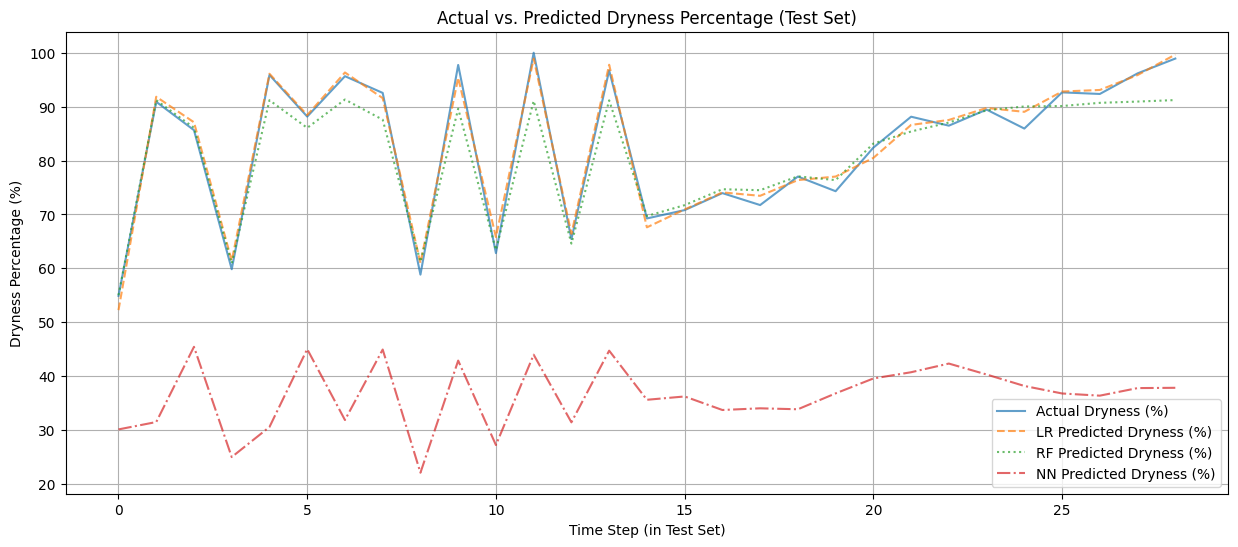

In [ ]:
#Step 7: Visualize Predictions
# Plot actual vs. predicted values for a subset of the test data

plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Dryness (%)', alpha=0.7)
plt.plot(y_pred_lr, label='LR Predicted Dryness (%)', linestyle='--', alpha=0.7)
plt.plot(y_pred_rf, label='RF Predicted Dryness (%)', linestyle=':', alpha=0.7)
plt.plot(y_pred_nn, label='NN Predicted Dryness (%)', linestyle='-.', alpha=0.7)

plt.title('Actual vs. Predicted Dryness Percentage (Test Set)')
plt.xlabel('Time Step (in Test Set)')
plt.ylabel('Dryness Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

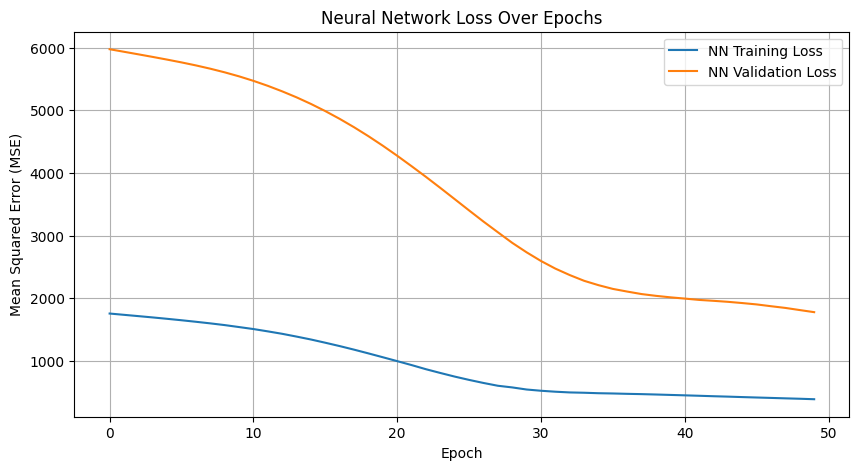

In [ ]:
# Plot training history for Neural Network (loss over epochs)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='NN Training Loss')
plt.plot(history.history['val_loss'], label='NN Validation Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 8: Compare Models and Select the Best

print("\n--- Model Comparison ---")

models_performance = {
    "Linear Regression": {"RMSE": rmse_lr, "R2": r2_lr, "Predictions": y_pred_lr},
    "Random Forest Regressor": {"RMSE": rmse_rf, "R2": r2_rf, "Predictions": y_pred_rf},
    "Neural Network": {"RMSE": rmse_nn, "R2": r2_nn, "Predictions": y_pred_nn}
}

best_model_name_rmse = None
min_rmse = float('inf')

best_model_name_r2 = None
max_r2 = float('-inf')

print("\nPerformance Metrics:")
for name, metrics in models_performance.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.4f}, R-squared = {metrics['R2']:.4f}")

    if metrics['RMSE'] < min_rmse:
        min_rmse = metrics['RMSE']
        best_model_name_rmse = name

    if metrics['R2'] > max_r2:
        max_r2 = metrics['R2']
        best_model_name_r2 = name

print(f"\nBased on RMSE, the best model is: {best_model_name_rmse} (RMSE: {min_rmse:.4f})")
print(f"Based on R-squared, the best model is: {best_model_name_r2} (R-squared: {max_r2:.4f})")


--- Model Comparison ---

Performance Metrics:
Linear Regression: RMSE = 1.5312, R-squared = 0.9869
Random Forest Regressor: RMSE = 3.6624, R-squared = 0.9249
Neural Network: RMSE = 47.2714, R-squared = -11.5074

Based on RMSE, the best model is: Linear Regression (RMSE: 1.5312)
Based on R-squared, the best model is: Linear Regression (R-squared: 0.9869)
